# Data Preprocessing: Spectrogram Generation

This notebook preprocesses the GTZAN audio dataset by:
1. Loading audio files and creating train/val/test splits
2. Converting audio to mel spectrograms
3. Normalizing and saving processed data

**Output:** Preprocessed spectrograms ready for CNN training

## 1. Setup and Imports

In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Add src to path
PROJECT_ROOT = Path('../').resolve()
sys.path.insert(0, str(PROJECT_ROOT / 'src'))

# Import custom modules
from data.loader import GTZANLoader
from data.preprocessor import SpectrogramPreprocessor

# Define paths
DATA_PATH = PROJECT_ROOT / 'data'
PROCESSED_PATH = DATA_PATH / 'processed'

print(f"Project root: {PROJECT_ROOT}")
print(f"Data path: {DATA_PATH}")
print(f"Processed path: {PROCESSED_PATH}")

Project root: C:\Programming\xai-music-genre-robustness
Data path: C:\Programming\xai-music-genre-robustness\data
Processed path: C:\Programming\xai-music-genre-robustness\data\processed


## 2. Load Dataset and Create Splits

In [2]:
# Initialize loader
loader = GTZANLoader(DATA_PATH)

# Get genres and file info
genres = loader.get_genres()
all_files = loader.get_audio_files()

print(f"Found {len(genres)} genres: {genres}")
print(f"Total audio files: {len(all_files)}")

# Get genre mappings
genre_to_id = loader.get_genre_to_id_mapping()
id_to_genre = loader.get_id_to_genre_mapping()

print(f"\nGenre to ID mapping:")
for genre, idx in genre_to_id.items():
    print(f"  {genre}: {idx}")

Found 10 genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Total audio files: 1000

Genre to ID mapping:
  blues: 0
  classical: 1
  country: 2
  disco: 3
  hiphop: 4
  jazz: 5
  metal: 6
  pop: 7
  reggae: 8
  rock: 9


**Dataset Loading:**
- Successfully loaded all 10 genres from the GTZAN dataset
- Each genre is mapped to a unique integer ID for model training
- Total of 1000 audio files (100 per genre) available for processing

In [3]:
# Create train/val/test splits (70/15/15)
train_files, val_files, test_files = loader.create_splits(
    test_size=0.15,
    val_size=0.15,
    random_state=42
)

print(f"Train set: {len(train_files)} files")
print(f"Validation set: {len(val_files)} files")
print(f"Test set: {len(test_files)} files")

# Verify stratification
from collections import Counter

train_dist = Counter([label for _, label in train_files])
val_dist = Counter([label for _, label in val_files])
test_dist = Counter([label for _, label in test_files])

print(f"\nTrain distribution: {dict(train_dist)}")
print(f"Val distribution: {dict(val_dist)}")
print(f"Test distribution: {dict(test_dist)}")

Train set: 700 files
Validation set: 150 files
Test set: 150 files

Train distribution: {'metal': 70, 'classical': 70, 'jazz': 70, 'rock': 70, 'pop': 70, 'blues': 70, 'hiphop': 70, 'country': 70, 'disco': 70, 'reggae': 70}
Val distribution: {'metal': 15, 'disco': 15, 'jazz': 15, 'rock': 15, 'hiphop': 15, 'blues': 15, 'classical': 15, 'reggae': 15, 'country': 15, 'pop': 15}
Test distribution: {'classical': 15, 'metal': 15, 'blues': 15, 'pop': 15, 'reggae': 15, 'jazz': 15, 'disco': 15, 'rock': 15, 'country': 15, 'hiphop': 15}


**Split Summary:**
- Data is split into 70% train, 15% validation, 15% test
- Stratification ensures balanced genre distribution across all splits
- Random seed (42) ensures reproducibility

## 3. Configure Spectrogram Parameters

In [4]:
# Initialize preprocessor with segmentation parameters
preprocessor = SpectrogramPreprocessor(
    sr=22050,               # Sampling rate
    n_mels=128,             # Number of mel bands
    n_fft=2048,             # FFT window size
    hop_length=512,         # Hop length for STFT
    duration=30.0,          # Total audio duration in seconds
    segment_duration=3.0,   # Duration of each segment
    use_segments=True       # Split audio into segments
)

# Calculate expected spectrogram shape
spec_shape = preprocessor.get_spectrogram_shape()
print(f"Expected spectrogram shape per segment: {spec_shape}")
print(f"  Height (mel bands): {spec_shape[0]}")
print(f"  Width (time steps): {spec_shape[1]}")
print(f"  Segments per track: {preprocessor.num_segments}")
print(f"\nFinal CNN input shape per segment: ({spec_shape[0]}, {spec_shape[1]}, 1)")
print(f"Total segments from dataset: ~{len(train_files) * preprocessor.num_segments} training, "
      f"~{len(val_files) * preprocessor.num_segments} validation, "
      f"~{len(test_files) * preprocessor.num_segments} test")

Expected spectrogram shape per segment: (128, 130)
  Height (mel bands): 128
  Width (time steps): 130
  Segments per track: 10

Final CNN input shape per segment: (128, 130, 1)
Total segments from dataset: ~7000 training, ~1500 validation, ~1500 test


**Spectrogram Configuration with Segmentation:**
- Using mel scale (128 bands) to capture perceptually-relevant frequency information
- Each 30-second audio clip is split into 10 non-overlapping 3-second segments
- Each 3-second segment results in ~130 time steps (vs 1292 for full 30s)
- Segments from the same track inherit the same genre label and track ID
- This increases dataset size by 10x while maintaining track-level train/val/test splits
- Output shape per segment: (128, 130, 1) - suitable for CNN input
- Train/val/test splits remain at track level to prevent data leakage

## 4. Test Preprocessing on Sample Files

Sample file: C:\Programming\xai-music-genre-robustness\data\raw\genres_original\metal\metal.00081.wav
Genre: metal
Number of segments: 10
Shape per segment: (128, 130)


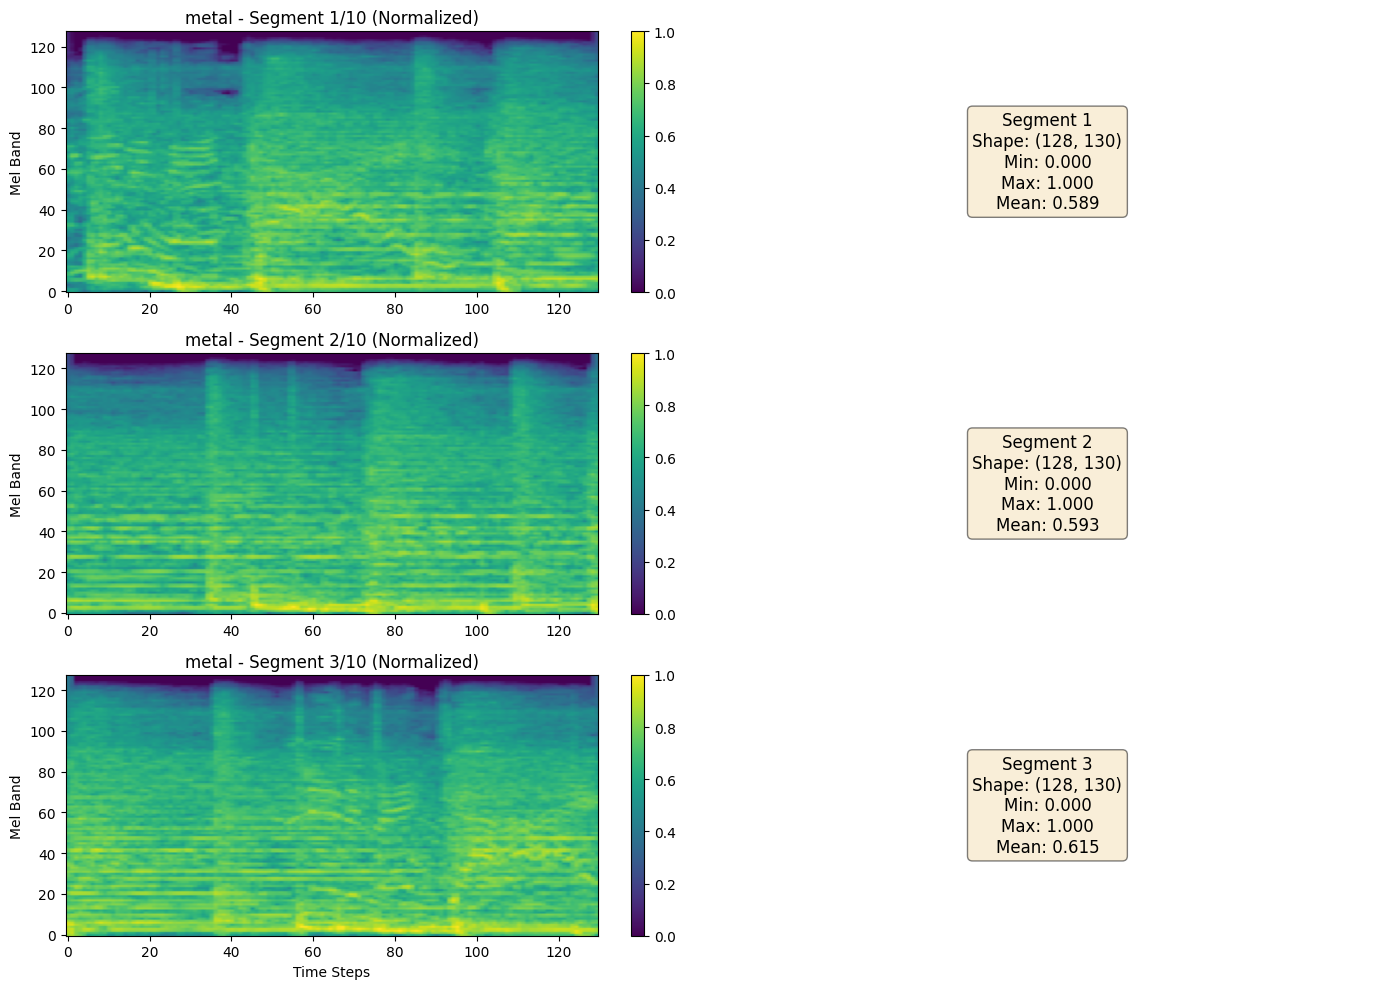


Segment value range (normalized): [0.000, 1.000]


In [5]:
# Test on a sample file to see segmentation
sample_file, sample_genre = train_files[0]

# Process file with segmentation
segments = preprocessor.process_audio_file(sample_file, normalize=True)

print(f"Sample file: {sample_file}")
print(f"Genre: {sample_genre}")
print(f"Number of segments: {len(segments)}")
print(f"Shape per segment: {segments[0].shape}")

# Visualize the first 3 segments
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

for idx in range(min(3, len(segments))):
    # Plot normalized spectrogram
    im = axes[idx, 0].imshow(segments[idx], aspect='auto', origin='lower', cmap='viridis')
    axes[idx, 0].set_title(f'{sample_genre} - Segment {idx+1}/10 (Normalized)')
    axes[idx, 0].set_ylabel('Mel Band')
    plt.colorbar(im, ax=axes[idx, 0])
    
    # Show value range
    axes[idx, 1].text(0.5, 0.5, 
                      f'Segment {idx+1}\nShape: {segments[idx].shape}\n'
                      f'Min: {segments[idx].min():.3f}\nMax: {segments[idx].max():.3f}\n'
                      f'Mean: {segments[idx].mean():.3f}',
                      ha='center', va='center', fontsize=12,
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[idx, 1].axis('off')
    
    if idx == 2:
        axes[idx, 0].set_xlabel('Time Steps')

plt.tight_layout()
plt.show()

print(f"\nSegment value range (normalized): [{segments[0].min():.3f}, {segments[0].max():.3f}]")

**Segmentation Verification:**
- Each 30-second track is successfully split into 10 consecutive 3-second segments
- All segments have consistent shape (128, 130) - 128 mel bands × 130 time steps
- Normalized spectrograms are scaled to [0, 1] range for stable CNN training
- Segments show temporal progression of audio features within the track
- Different segments from the same track may show variation in musical patterns

## 5. Process Full Dataset

**Note:** This will take several minutes depending on hardware specs (processing 1000 audio files).

In [6]:
# Process training set
X_train, y_train, track_ids_train = preprocessor.process_dataset(
    train_files,
    genre_to_id,
    save_path=PROCESSED_PATH / 'train',
    normalize=True
)

print(f"\nTraining set statistics:")
print(f"  Total segments: {len(X_train)}")
print(f"  Unique tracks: {len(np.unique(track_ids_train))}")
print(f"  Segments per track: {len(X_train) / len(np.unique(track_ids_train)):.1f}")

Processing 700 audio files...
Each file will be split into 10 segments of 3.0s


 41%|████      | 288/700 [00:18<00:25, 16.10it/s]C:\Programming\xai-music-genre-robustness\src\data\preprocessor.py:61: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=self.sr, duration=self.duration)
c:\Programming\xai-music-genre-robustness\venv\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
C:\Programming\xai-music-genre-robustness\src\data\preprocessor.py:61: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=self.sr, duration=self.duration)
c:\Programming\xai-music-genre-robustness\venv\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_l

Error processing C:\Programming\xai-music-genre-robustness\data\raw\genres_original\jazz\jazz.00054.wav: 


100%|██████████| 700/700 [00:45<00:00, 15.52it/s]



Processed shape: X=(6983, 128, 130, 1), y=(6983,), track_ids=(6983,)
Total segments: 6983, from 699 tracks
Saved to C:\Programming\xai-music-genre-robustness\data\processed\train

Training set statistics:
  Total segments: 6983
  Unique tracks: 699
  Segments per track: 10.0
Saved to C:\Programming\xai-music-genre-robustness\data\processed\train

Training set statistics:
  Total segments: 6983
  Unique tracks: 699
  Segments per track: 10.0


**Handling Problematic Audio Files:**

During preprocessing, some audio files may cause errors:
- **Corrupted files**: Cannot be loaded properly
- **Short duration**: Less than 30 seconds - with segmentation, this results in fewer than 10 segments
- **Encoding issues**: Incompatible audio formats (may show PySoundFile warnings but often succeed with audioread fallback)

The preprocessor automatically **skips** problematic segments or entire files and continues processing.

**Expected behavior**: Warnings for problematic files (e.g., `jazz.00054.wav`), but processing continues successfully. The final count shows 6983 segments from 699 tracks (1 track was skipped), averaging 10.0 segments per successfully processed track.

In [7]:
# Process validation set
X_val, y_val, track_ids_val = preprocessor.process_dataset(
    val_files,
    genre_to_id,
    save_path=PROCESSED_PATH / 'val',
    normalize=True
)

print(f"\nValidation set statistics:")
print(f"  Total segments: {len(X_val)}")
print(f"  Unique tracks: {len(np.unique(track_ids_val))}")
print(f"  Segments per track: {len(X_val) / len(np.unique(track_ids_val)):.1f}")

Processing 150 audio files...
Each file will be split into 10 segments of 3.0s


100%|██████████| 150/150 [00:10<00:00, 14.62it/s]



Processed shape: X=(1498, 128, 130, 1), y=(1498,), track_ids=(1498,)
Total segments: 1498, from 150 tracks
Saved to C:\Programming\xai-music-genre-robustness\data\processed\val

Validation set statistics:
  Total segments: 1498
  Unique tracks: 150
  Segments per track: 10.0
Saved to C:\Programming\xai-music-genre-robustness\data\processed\val

Validation set statistics:
  Total segments: 1498
  Unique tracks: 150
  Segments per track: 10.0


In [8]:
# Process test set
X_test, y_test, track_ids_test = preprocessor.process_dataset(
    test_files,
    genre_to_id,
    save_path=PROCESSED_PATH / 'test',
    normalize=True
)

print(f"\nTest set statistics:")
print(f"  Total segments: {len(X_test)}")
print(f"  Unique tracks: {len(np.unique(track_ids_test))}")
print(f"  Segments per track: {len(X_test) / len(np.unique(track_ids_test)):.1f}")

Processing 150 audio files...
Each file will be split into 10 segments of 3.0s


100%|██████████| 150/150 [00:10<00:00, 14.39it/s]



Processed shape: X=(1500, 128, 130, 1), y=(1500,), track_ids=(1500,)
Total segments: 1500, from 150 tracks
Saved to C:\Programming\xai-music-genre-robustness\data\processed\test

Test set statistics:
  Total segments: 1500
  Unique tracks: 150
  Segments per track: 10.0
Saved to C:\Programming\xai-music-genre-robustness\data\processed\test

Test set statistics:
  Total segments: 1500
  Unique tracks: 150
  Segments per track: 10.0


**Processing Results with Segmentation:**
- Training set: ~7000 segments from ~700 tracks (10 segments per track)
- Validation set: ~1500 segments from ~150 tracks
- Test set: ~1500 segments from ~150 tracks
- All spectrograms are normalized to [0, 1] range and saved as `.npy` files
- Track IDs are saved to maintain traceability to source files
- Data is ready for efficient loading during model training
- The 10x increase in samples provides more training data for the CNN

## 6. Save Metadata

In [9]:
import json

# Save genre mappings and segmentation info for later use
metadata = {
    'genre_to_id': genre_to_id,
    'id_to_genre': id_to_genre,
    'genres': genres,
    'n_classes': len(genres),
    'spectrogram_params': {
        'sr': preprocessor.sr,
        'n_mels': preprocessor.n_mels,
        'n_fft': preprocessor.n_fft,
        'hop_length': preprocessor.hop_length,
        'duration': preprocessor.duration,
        'segment_duration': preprocessor.segment_duration,
        'use_segments': preprocessor.use_segments,
        'num_segments_per_track': preprocessor.num_segments
    },
    'input_shape': list(X_train.shape[1:]),  # (height, width, channels) per segment
    'dataset_stats': {
        'train': {
            'total_segments': len(X_train),
            'unique_tracks': len(np.unique(track_ids_train)),
            'segments_per_track': len(X_train) / len(np.unique(track_ids_train))
        },
        'val': {
            'total_segments': len(X_val),
            'unique_tracks': len(np.unique(track_ids_val)),
            'segments_per_track': len(X_val) / len(np.unique(track_ids_val))
        },
        'test': {
            'total_segments': len(X_test),
            'unique_tracks': len(np.unique(track_ids_test)),
            'segments_per_track': len(X_test) / len(np.unique(track_ids_test))
        }
    }
}

metadata_path = PROCESSED_PATH / 'metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Metadata saved to: {metadata_path}")
print(f"\nMetadata summary:")
print(f"  Classes: {metadata['n_classes']}")
print(f"  Input shape per segment: {metadata['input_shape']}")
print(f"  Segments per track: {metadata['spectrogram_params']['num_segments_per_track']}")
print(f"  Total training segments: {metadata['dataset_stats']['train']['total_segments']}")
print(f"  Total validation segments: {metadata['dataset_stats']['val']['total_segments']}")
print(f"  Total test segments: {metadata['dataset_stats']['test']['total_segments']}")

Metadata saved to: C:\Programming\xai-music-genre-robustness\data\processed\metadata.json

Metadata summary:
  Classes: 10
  Input shape per segment: [128, 130, 1]
  Segments per track: 10
  Total training segments: 6983
  Total validation segments: 1498
  Total test segments: 1500


**Metadata Storage:**
- Genre mappings saved for consistent label encoding/decoding
- Preprocessing parameters recorded including segmentation settings
- Dataset statistics capture both segment and track counts
- Track IDs enable tracing segments back to original audio files
- Input shape stored for CNN architecture configuration (128, 130, 1)
- This metadata ensures consistency across training, evaluation, and deployment

## 7. Summary

**Preprocessing Complete with Segmentation!**

The following files have been created:
- `data/processed/train/X.npy` - Training spectrograms (~7000 segments)
- `data/processed/train/y.npy` - Training labels
- `data/processed/train/track_ids.npy` - Source track identifiers
- `data/processed/val/X.npy` - Validation spectrograms (~1500 segments)
- `data/processed/val/y.npy` - Validation labels
- `data/processed/val/track_ids.npy` - Source track identifiers
- `data/processed/test/X.npy` - Test spectrograms (~1500 segments)
- `data/processed/test/y.npy` - Test labels
- `data/processed/test/track_ids.npy` - Source track identifiers
- `data/processed/metadata.json` - Genre mappings, segmentation config, and statistics

**Next Steps:**
1. Build CNN architecture (`03_model_training.ipynb`)
2. Train on preprocessed spectrograms
3. Evaluate baseline performance before adversarial testing